# Trabajo practico 1: Clasificiones con Decision Trees y Naive Bayes
### Integrantes: Rodrigo Mauriño, Martin Llada, Juan Jose Iguaran

La base de datos consiste en informacion sobre creditos para vivivienda en el estado de Nueva York, EE.UU. y el objetivo del ejercicio es lograr entrenar modelos clasificatorios que permitan predecir si el aplicante n, dados los valores de los atributos X, es elegible para el credito.  <br> Para proceder a entrenar los modelos clasificatorios, es necesario alistar el framework mediante la importacion de las librerias necesarias:

In [85]:
import os
import pandas as pd 
import numpy as np
import sklearn as sk
import random
from sklearn import model_selection
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

Una vez importadas las librerias, es necesario importar el dataset a ser utlizado, asi como una pequeña visualizacion del mismo:

In [2]:
data = pd.read_csv("baseclean.csv")
dataf=data.copy()
dataf=dataf.dropna()
dataf.head()

,action_taken,agency_code,applicant_ethnicity,applicant_income_000s,applicant_race_1,applicant_sex,application_date_indicator,census_tract_number,co_applicant_ethnicity,co_applicant_race_1,...,property_type,purchaser_type,sequence_number,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,tract_to_msamd_income
0,1,9,3,230.0,6,3,0,319.00,5,8,...,1,0,155085,82700.0,159,2414.0,2077.0,14.770000,7442.0,138.440002
1,1,7,1,66.0,6,1,0,602.02,3,5,...,2,0,37462,95200.0,47,1422.0,1298.0,19.690001,3997.0,85.000000
3,1,5,2,174.0,5,1,0,502.03,2,5,...,1,0,20,95200.0,40,1723.0,1578.0,17.639999,4971.0,119.169998
4,1,9,2,100.0,5,2,0,195.00,5,8,...,1,0,12370,71300.0,378,615.0,738.0,60.779999,3366.0,78.169998
5,1,7,2,155.0,5,1,0,3037.00,2,5,...,1,1,143,109000.0,352,2008.0,2041.0,22.570000,6718.0,87.589996


Puesto que una delas variables, especificamente, el nombre del condado es un string, se procede a realizar una transformacion en numerica mediante label_encoder y luego reemplazar los valores originales por los obtenidos a partir de la transformacion para poder ejecutar el algoritmo. Asi mismo, es necesario transformar la variable objetivo action_taken en binario para poder luego calcular medidas de desempeño, asi que se procede crear una lista que contiene los indices que resultaron en un credito aprobado, para asignar 1 si la entrada esta dentro de los valores de la lista, o 0 en caso contrario::

In [3]:
values = np.array(dataf["county_name"])
integer_encoded = sk.preprocessing.LabelEncoder().fit_transform(values)
dataf.loc[:,"county_name"]=integer_encoded
lista = [1,5,6]
target_encoded =dataf['action_taken'].isin(lista).astype(int)

## 1) Particion de datos
Ahora que los datos se encuentran en un formato apto para el modelo, se procede a ejecutar su particion. Esta particion tendra como varible objetivo la decision tomada, y como parametros las demas columnas. Consistira en un 80% de los datos para desarrollo y en un 20% para test:

In [4]:
X=dataf.iloc[:,1:]
Y=target_encoded
dev_x, test_x, dev_y, test_y = model_selection.train_test_split(X,Y,train_size=0.8, test_size=0.2,random_state=123)

## 2) Arboles de decision

### 2.1) Arbol de altura 3

Con el objetivo de realizar una validacion cruzada que permita calcular las medidas de desempeño tanto para los datos de entrenamiento como para los de validacion, se procede a implementar la funcion cross_val_nuevo(x_set, y_set, n_folds, tree, perf) que tomara como entrada el set de datos, el set de datos a predecir, el numero de particiones, un modelo predictivo y el tipo de medida de desempeño. Tendra como salida dos listas, ambas de longitud del numero de particiones, la primera seran los puntajes para los datos de entrenamiento y la segunda seran los puntajes para los datos de validacion:

In [5]:
def cross_val_nuevo(x_set, y_set, n_folds, model, perf):
    tree = sk.base.clone(model)
    index = random.sample(range(x_set.shape[0]), x_set.shape[0])
    n = int(x_set.shape[0]/n_folds)
    list_x = []
    list_y = []
    train_score = []
    val_score = []
    for i in range(n_folds):
        fold_x = x_set.iloc[index[n*i:n*(i+1)],].copy()
        list_x.append(fold_x)
        fold_y = y_set.iloc[index[n*i:n*(i+1)],].copy()
        list_y.append(fold_y)
    for i in range(n_folds):
        val_x = list_x[i].copy()
        val_y = list_y[i].copy()
        train_x = list_x.copy()
        train_y = list_y.copy()
        del train_x[i]
        del train_y[i]
        x = pd.concat(train_x)
        y = pd.concat(train_y)
        tree.fit(x,y)
        pred_train = tree.predict(x)
        pred_val = tree.predict(val_x)
        if perf == 'acc':
            train_score.append(round(sk.metrics.accuracy_score(y,pred_train), 3))
            val_score.append(round(sk.metrics.accuracy_score(val_y,pred_val), 3))
        elif perf == 'roc':
            train_score.append(round(sk.metrics.roc_auc_score(y,pred_train), 3))
            val_score.append(round(sk.metrics.roc_auc_score(val_y,pred_val), 3))
    return train_score,val_score        

Se procede a crear un objeto tipo DecisionTreeClassifier con altura maxima altura 3 manteniendo el resto de los hiperparametros en su valor preestablecido:

In [6]:
dtree =sk.tree.DecisionTreeClassifier(max_depth = 3)

Una vez creado el objeto, se procede a estimar el desempeño del modelo utilizando 5-fold cross validation a travez de la funcion  cross_val_nuevo utilizando la medida de accuracy:

In [7]:
perf_3tree = cross_val_nuevo(dev_x, dev_y, 5, dtree, 'acc')
perf_3tree

([0.795, 0.784, 0.795, 0.783, 0.801], [0.755, 0.8, 0.777, 0.802, 0.772])

Se puede apreciar que para el arbol entrenado, la precision se encuentra alrededor del 80% aproximadamentepara los datos de entrenamiento. Asi mismo, se evidencia que para los datos de validacion se tiene una medida parecida de performance. Se procede a estimar el desempño sobre el mismo arbol, pero esta vez utilizando roc_auc:

In [8]:
perf_3tree_roc = cross_val_nuevo(dev_x, dev_y, 5, dtree, 'roc')
perf_3tree_roc

([0.793, 0.779, 0.8, 0.783, 0.79], [0.764, 0.719, 0.772, 0.809, 0.799])

Los resultados obtenidos utilizando esta medida son parecidos a lo obtenidos utilizando accuracy, aunque se puede apreciar que son levemente inferiores. A continuacion se calcularan las medias y los desvios estandar para todos las medidas de performance, para ello, primero se transformaran las listas en un arreglo de numpy:

In [9]:
train_acc = np.array(perf_3tree[0])
val_acc = np.array(perf_3tree[1])
train_roc = np.array(perf_3tree_roc[0])
val_roc = np.array(perf_3tree_roc[1])
print(round(train_acc.mean(),3))
print(round(train_acc.std(),3))
print(round(val_acc.mean(),3))
print(round(val_acc.std(),3))
print(round(train_roc.mean(),3))
print(round(train_roc.std(),3))
print(round(val_roc.mean(),3))
print(round(val_roc.std(),3))

0.792
0.007
0.781
0.018
0.789
0.007
0.773
0.032


Se puede apreciar que para ambas medidas, la media es mas alta y la desviacion estandar mas baja para los datos de entrenamiento, lo que es consecuente pues el modelo se comporta mejor para los datos con los que fue entrenado. Por otro lado, tambien se evidencia que la medida de acucracy es significativamente mejor en todos los casos que el roc_auc.

### 2.2) Arboles de diferentes combinaciones


Con el objetivo de tener una comparacion de desempeño al variar los hiperparametros, se procede a crear un nuevo arbol de la misma profundidad, pero esta vez utilizando como criterio information gane en lugar de Gini:

In [10]:
dtree_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)

Con el nuevo arbol, se calcularan las mismas metricas obtenidas anteriormente:

In [11]:
acc_results_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_ig, 'acc')
roc_results_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_ig, 'roc')
print(acc_results_ig)
print(roc_results_ig)

([0.802, 0.795, 0.79, 0.788, 0.782], [0.786, 0.775, 0.777, 0.782, 0.806])
([0.798, 0.783, 0.792, 0.79, 0.821], [0.767, 0.768, 0.78, 0.782, 0.798])


No se evidencia una diferencia significativa entre las medidas obtenidas a partir de la utiliacion de infromation gane. A continuacion se crearan dos arboles utilizando ambos criterios pero esta vez, con una altura de 6:

In [12]:
dtree_6_gn= sk.tree.DecisionTreeClassifier(max_depth = 6)
dtree_6_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)

Se calcularan ahora las metricas de costumbre, iniciando con el arbol creado utilizando GINI:

In [13]:
acc_results_6 = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_gn, 'acc')
roc_results_6 = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_gn, 'roc')
print(acc_results_6)
print(roc_results_6)

([0.862, 0.84, 0.858, 0.85, 0.848], [0.795, 0.838, 0.797, 0.829, 0.782])
([0.821, 0.838, 0.823, 0.839, 0.861], [0.793, 0.797, 0.766, 0.792, 0.782])


Es apreciable la mejora en el desempeño para todas las metricas estudiadas, por lo que es concluible que un arbol de profundidad 6 se ajusta mejor al dataset en cuestion. Ahora se calcularan las mismas metricas para el arbol entrenado a partir de information gane:

In [14]:
acc_results_6_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_ig, 'acc')
roc_results_6_ig = cross_val_nuevo(dev_x, dev_y, 5, dtree_6_ig, 'roc')
print(acc_results_6_ig)
print(roc_results_6_ig)

([0.855, 0.855, 0.852, 0.847, 0.856], [0.827, 0.811, 0.809, 0.802, 0.782])
([0.858, 0.809, 0.832, 0.798, 0.831], [0.793, 0.776, 0.806, 0.767, 0.796])


Se puede evidenciar como las metricas son bastante similares a las observadas con la utilizacion de GINI, sin embargo, aunque algunas tuvieron mejor desempeño, puede decirse que hay una leve mejoria con GINI. Ahora se creara un arbol sin ninguna especificacion de altura maxima para ambos criterios:

In [15]:
dtree_max_gn= sk.tree.DecisionTreeClassifier()
dtree_max_ig= sk.tree.DecisionTreeClassifier(criterion = 'entropy')

De la misma manera que para el arbol anterior, se calcularan las metricas de costumbre utilizando GINI:

In [16]:
acc_results_max = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_gn, 'acc')
roc_results_max = cross_val_nuevo(dev_x, dev_y, 5, dtree_max_gn, 'roc')
print(acc_results_max)
print(roc_results_max)

([1.0, 1.0, 1.0, 1.0, 1.0], [0.766, 0.779, 0.732, 0.779, 0.802])
([1.0, 1.0, 1.0, 1.0, 1.0], [0.715, 0.73, 0.748, 0.758, 0.725])


Resalta el hecho de que al no especificar la profundidad, el modelo incurre en overfitting, pues predeice de manera exacta para los datos de entrenamiento enn ambas medidas, sin embargo, los puntajes para los datos de validacion son menores que los obtenidos para los arboles anteriores, por lo que pierde capacidad de prediccion.

## 2.3) Tratamiento de datos faltantes

Para evaluar la influencia de la cantidad de datos faltantes en un data set, y la estrategia de relleno que se implemente, a continuacion se implementa la funcion outliers(data,clase, index, por, rell), que recibira el set de datos asi como la variable a predecir, el indice del atributo a modificar, un porcentaje de datos faltantes y una estrategia de de relleno que podra ser moda o clase modal, y devolvera como salida un nuevo data frame que tendra el porcentaje de datos faltantes rellenados con la estrategia de relleno:

In [17]:
def outliers(data,clase,index, por, rell):
    new = data.copy()
    n = int(new.shape[0]*(por/100))
    rand = random.sample(range(new.shape[0]), n) 
    for i in rand:
        new.iloc[i,index] = np.nan
    if rell == 'mode':
        mode = int(new.iloc[:,index].mode())
        for i in rand:
            new.iloc[i,index] = mode
    elif rell == 'class_mode':
        feat = new.iloc[:,index]
        for i in rand:
            mode = int(feat[clase == clase.iloc[i]].mode())
            new.iloc[i,index] = mode
    return new

Para las siguientes evaluaciones se utilizara el 80% de los datos de desarrollo, pues el otro 20% sera empleado en validacion:

In [18]:
des_x, val_x, des_y, val_y = model_selection.train_test_split(dev_x,dev_y,train_size=0.8, test_size=0.2,random_state=123)

Con lo observado anteriormente a partir de las metricas, se puede concluir que de los arboles previamente evaluados, aquel que tuvo mejor desempeño fue el construido a partir de GINI con una profundidad maxima de 6, por lo que para los siguientes analisis se utilizara dicha configuracion. Para evaluar la influencia de los datos faltantes, el proceso sera mas notorio si estos datos faltan en el atrbuto mas relevante, por lo que a continuacion se creara y entrenara un arbol con las caracteristicas previamente mencionadas para obtener el indice de dicho atributo:

In [19]:
opt_tree= sk.tree.DecisionTreeClassifier(max_depth = 6)
opt_tree.fit(des_x,des_y)
importance = opt_tree.feature_importances_
index = np.argmax(importance)
print(index)

20


### 2.3 a) Ejecucion en distintos datasets

Conociendo cual es el indice del atributo mas importante se procedera a generar una lista de datasets con diferentes cantidades de datos faltantes, desde 0 a 80% variando en intervalos de 5%, tanto para el metodo de modas como para el de modas de clase, para evaluar el desempeño de arboles entrenados con cada uno de estos datasets:

In [77]:
list_mode = []
list_class_mode = []
list_mode.append(des_x.copy())
list_class_mode.append(des_x.copy())
for i in range(5,85,5):
    list_mode.append(outliers(des_x,des_y,index, i, 'mode'))    
    list_class_mode.append(outliers(des_x,des_y,index, i, 'class_mode'))

Una vez creados los datasets, se procede a entrenar modelos con ellos para calcular el tamaño y el performance de cada uno para poder compararlos segun estas medidas:

In [78]:
tree_size_mode = []
acc_mode = []
tree_size_class_mode = []
acc_class_mode =[]
for i in range(len(list_mode)):
    tree_mode = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_mode.fit(list_mode[i],des_y)
    tree_size_mode.append(tree_mode.tree_.node_count)
    pred_mode = tree_mode.predict(val_x)
    acc_mode.append(sk.metrics.accuracy_score(val_y,pred_mode))
    tree_class_mode = sk.tree.DecisionTreeClassifier(max_depth = 6)
    tree_class_mode.fit(list_class_mode[i],des_y)
    tree_size_class_mode.append(tree_class_mode.tree_.node_count)
    pred_class_mode = tree_class_mode.predict(val_x)
    acc_class_mode.append(sk.metrics.accuracy_score(val_y,pred_class_mode)) 

### 2.3 b) Tamaño del arbol vs porcentaje de faltantes

A continuacion se realizan las graficas del tamaño del arbol en funcion del porcentaje de faltantes tanto para los reemplazados por modo, como por clase modal, para poder pareciar el comportamiento:

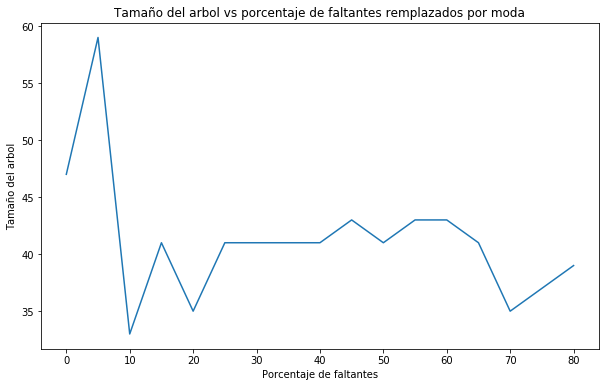

In [79]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), tree_size_mode)
plt.title('Tamaño del arbol vs porcentaje de faltantes remplazados por moda')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de faltantes')
plt.show()

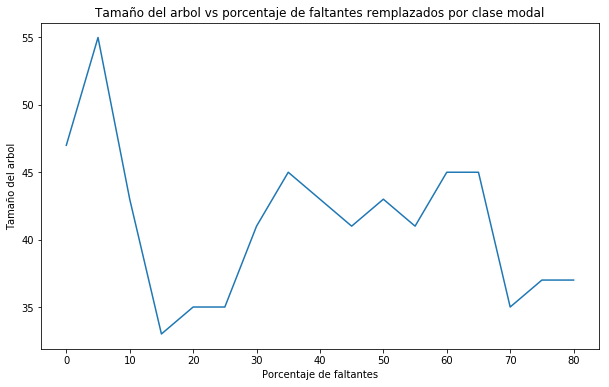

In [80]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), tree_size_class_mode)
plt.title('Tamaño del arbol vs porcentaje de faltantes remplazados por clase modal')
plt.ylabel('Tamaño del arbol')
plt.xlabel('Porcentaje de faltantes')
plt.show()

Aun cuando existen leves diferencias entre las graficas, se puede concluir que obedecen a la misma tendencia: a mayor porcentaje de faltantes disminuye el tamaño del arbol. 

### 2.3 c) Performance vs porcentaje de faltantes

De igual manera, se realizan las graficas del performance en funcion del porcentaje de faltantes tanto para los reemplazados por modo, como por clase modal, para poder pareciar el comportamiento:

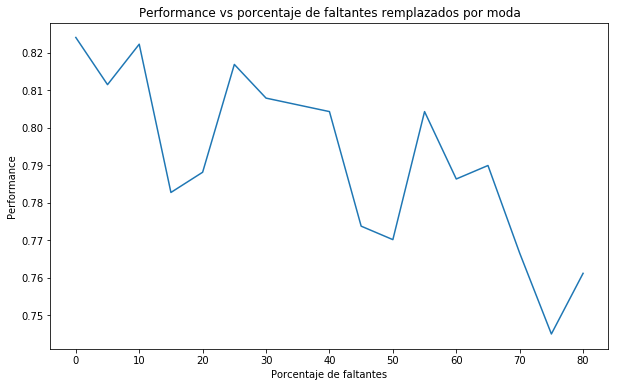

In [81]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), acc_mode)
plt.title('Performance vs porcentaje de faltantes remplazados por moda')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de faltantes')
plt.show()

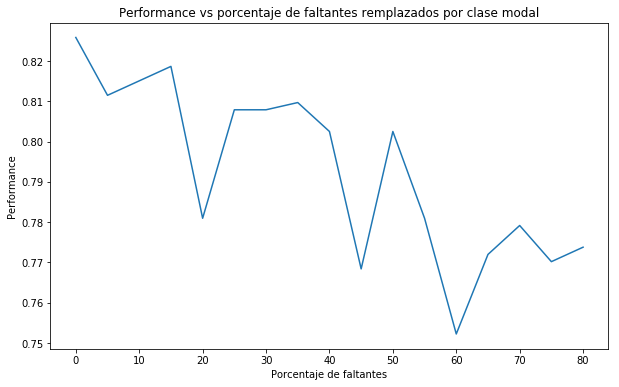

In [82]:
plt.figure(figsize=(10,6))
plt.plot(list(range(0,85,5)), acc_class_mode)
plt.title('Performance vs porcentaje de faltantes remplazados por clase modal')
plt.ylabel('Performance')
plt.xlabel('Porcentaje de faltantes')
plt.show()

Al igual que con el tamaño del arbol,aun cuando existen leves diferencias entre las graficas, se puede concluir que obedecen a la misma tendencia: a mayor porcentaje de faltantes disminuye el performance.

###  2.3 d) Analisis

Los comportamientos de las graficas anteriores apuntan en la misma direccion: el arbol disminuye su capacidad para generar caminos exitosos con el incremento de ruido y por consiguiente su capacidad predecir. A pesar de ligeras diferencias, el comportamiento de ambas estrategias de relleno es bastante similar, asi que puede concluirse que es indistinto utilizar alguna de estas para el tratamiento de outliers.

## 4) Tolerancia al ruido.
Para implemetar este inciso se utilizó la partición de datos realizada en la seccion 1.1.1.

## 4.1) Familia de datasets

In [61]:
import random 

#dev_x
#test_x
#train_X
#val_X
train_X_ruido=train_X.copy()

In [62]:
def ind_ruido(dataset,porcentaje):
    for i in range(0,int(len(dataset)*porcentaje)):
        newdataset = dataset.copy()
        a=random.randrange(0, int(len(dataset)*porcentaje))
        #b=random.randrange(0, b_ruido.shape[1])
        #noise = np.random.normal(0,5,1)
        noise = np.random.normal(dataset.iloc[:,21].mean(),dataset.iloc[:,21].mean()+100000,1)
        valor=(dataset.iloc[a,21])+noise
        #newdataset["purchaser_type"][a]=valor
        newdataset.iloc[a,21]=valor
    #mean=newdataset.iloc[:,21].mean()    
    #return newdataset,mean 
    return newdataset

In [68]:
#0.15,0.2,0.25,0.3,0.35
print(train_X_ruido.iloc[:,21].mean())
print(train_X_ruido.iloc[:,21].std())
noise = np.random.normal(train_X_ruido.iloc[:,21].mean(),train_X_ruido.iloc[:,21].mean()+100000,1)
print(noise)
print(lista[1].iloc[:,21].mean())
print(lista[1].iloc[:,21].std())
print(lista[2].iloc[:,21].mean())
print(lista[2].iloc[:,21].std())

109356.95820224719
221371.78554289247
[-20381.88135726]
109420.30706786698
221361.47643331048
109355.73621584859
221370.6537980745


In [63]:
rango=[0.05,0.25,0.1,0.15,0.2,0.25,0.3,0.35]
lista= []
#media=[]
for z in rango:
    #a,b = ind_ruido(train_X_ruido,z)
    a = ind_ruido(train_X_ruido,z)
    lista.append(a)
    #media.append(b)
    

 ## 4.2) Arboles de decisión

### 4.2.1) Arbol de altura 3
Se procede a crear un objeto tipo DecisionTreeClassifier con altura maxima altura 3 manteniendo el resto de los hiperparametros en su valor preestablecido, para luego entrenar dicho objeto con las particiones previamente definidas:

In [64]:
tree=[]
for dt in lista:
    dtree= sk.tree.DecisionTreeClassifier(max_depth = 3)
    q=dtree.fit(dt, train_y)
    tree.append(q)
  

Una vez entrenado el modelo, se procede a estimar el desempeño del modelo utilizando 5-fold cross validation:

In [65]:
acc_train=[]
for ac in range(0,len(tree)):
    acc_results_train = model_selection.cross_val_score(tree[ac], lista[ac], train_y, cv=5, scoring='accuracy')
    acc_train.append(acc_results_train)
    print(acc_train[ac].mean())  

0.7811338269291612
0.7811338269291612
0.7811338269291612
0.7811338269291612
0.7811338269291612
0.7811338269291612
0.7811338269291612
0.7811338269291612


Se puede apreciar que para el arbol entrenado, la precision se encuentra alrededor del 78% aproximadamente, lo que evidencia cierta tolerancia al ruido por parte de este algortimo supervizado. A continuacion se procede a calcular el ROC AUC para el conjunto de entrenamiento:

In [69]:
roc_train=[]
for roc in range(0,len(tree)):
    roc_results_train = model_selection.cross_val_score(tree[roc], lista[roc], train_y, cv=5, scoring='roc_auc')
    roc_train.append(roc_results_train)
    print(roc_train[roc].mean())

0.8634270511131478
0.8634270511131478
0.8634270511131478
0.8634270511131478
0.8634270511131478
0.8634270511131478
0.8634270511131478
0.8634270511131478


Los puntajes obtenidos utilizando roc_auc son superiores a los obtenidos por precision pues se encuentran alrededor del 86%. A su vez, se puede observar que dicho nivel de precision es similar al obtenido a partir de un dataset sin presencia de ruido. A continuacion se calcularan las mismas medidas de desempeño utilizando los datos de validacion:

In [70]:
acc_val=[]
roc_val=[]
for az in range(0,len(tree)):
    acc_results_val = model_selection.cross_val_score(tree[az], val_X, val_y, cv=5, scoring='accuracy')
    acc_val.append(acc_results_val)
    roc_results_val = model_selection.cross_val_score(tree[az], val_X, val_y, cv=5, scoring='roc_auc')
    roc_val.append(roc_results_val)
    print(acc_val[az].mean())
    print(roc_val[az].mean())

0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207
0.7557672282672283
0.8449849206349207


A partir de estos resultados, se puede apreciar que los valores para amba medidas son muy parecidas a aquellas obtenidas con el set de entrenamiento, por lo que puede concluirse que no se incurrio en overfitting. Se procede a calcular la media y la desviacion estandar de los distintos folds para la precision, tanto para los datos de validacion, como para los de entrenamiento:

In [45]:
for i in range(0,len(tree)):
    print(acc_train[i].mean())
    print(acc_train[i].std())
    print(acc_val[i].mean())
    print(acc_val[i].std())

0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331
0.7811338269291612
0.011734489995451241
0.7557672282672283
0.02285568790785331


A partir de analizar la media y la desviacion estandar de los distintos folds para la precision, tanto para los datos de validacion, como para los de entrenamiento, se desprende que las medidas de entrenamiento poseen una mayor media y una menor desviacion estandar respecto de las medidas de validacion. Este resultado parece logico teniendo en cuenta que el conjunto de validacion no se ha utilziado para entrenar el algoritmo. Ahora se realizaran las mismas metricas con los datos obtenidos para ROC AUC:

In [46]:
for i in range(0,len(tree)):
    print(roc_train[i].mean())
    print(roc_train[i].std())
    print(roc_val[i].mean())
    print(roc_val[i].std())

0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542
0.8634270511131478
0.015167646872192912
0.8449849206349207
0.02912565261173542


A partir de este ultimo ejercicio, se observa el mismo patron que el observado en el caso de la precision: mayor media y menor desvio se aprencian en el cojunto de entrenamiento; comportamiento que obedece a lo anteriormente explicado.

### 4.2.2) Arboles de diferentes combinaciones
Con el objetivo de tener una comparacion de desempeño al variar los hiperparametros, se procede a entrenar un nuevo arbol de la misma profundidad, pero esta vez utilizando como criterio information gain en lugar de Gini, para cada uno de los dataset con ruido:

In [71]:
tree_ig=[]
for dt in lista:
    dtree= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)
    q=dtree.fit(dt, train_y)
    tree_ig.append(q)

Con el nuevo arbol, se calcularan las mismas metricas obtenidas anteriormente:

In [72]:
acc_train_ig=[]
for ac in range(0,len(tree_ig)):
    acc_results_train_ig = model_selection.cross_val_score(tree_ig[ac], lista[ac], train_y, cv=5, scoring='accuracy')
    acc_train_ig.append(acc_results_train_ig)
    print(acc_train_ig[ac].mean()) 

roc_train_ig=[]
for ac in range(0,len(tree_ig)):
    roc_results_train_ig = model_selection.cross_val_score(tree_ig[ac], lista[ac], train_y, cv=5, scoring='roc_auc')
    roc_train_ig.append(roc_results_train_ig)
    print(roc_train_ig[ac].mean()) 

acc_val_ig=[]
roc_val_ig=[]
for az in range(0,len(tree_ig)):
    acc_results_val_ig = model_selection.cross_val_score(tree_ig[az], val_X, val_y, cv=5, scoring='accuracy')
    acc_val_ig.append(acc_results_val_ig)
    roc_results_val_ig = model_selection.cross_val_score(tree_ig[az], val_X, val_y, cv=5, scoring='roc_auc')
    roc_val_ig.append(roc_results_val_ig)
    print(acc_val_ig[az].mean())
    print(roc_val_ig[az].mean())
    

0.7707734665688009
0.7707734665688009
0.7707734665688009
0.7707734665688009
0.7707734665688009
0.7707734665688009
0.7707734665688009
0.7707734665688009
0.8616238103724069
0.8616238103724069
0.8616238103724069
0.8616238103724069
0.8616238103724069
0.8616238103724069
0.8616238103724069
0.8616238103724069
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886
0.7575529425529426
0.8397948621553886


In [49]:
print(acc_results_train_ig)
print(roc_results_train_ig)
print(acc_results_val_ig)
print(roc_results_val_ig)

[0.76233184 0.79147982 0.7752809  0.74774775 0.77702703]
[0.84161989 0.87178371 0.85619694 0.85479167 0.88372685]
[0.78571429 0.75       0.76785714 0.73873874 0.74545455]
[0.84502924 0.87737573 0.84539474 0.82888889 0.80228571]


Se puede apreciar los valores de ROC AUC son muy parecidos a los obtenidos utilizando GINI como criterio. A continuacion se entrenaran dos arboles utilizando ambos criterios pero esta vez, con una altura de 6:

In [74]:
tree_6_gn=[]
for dt in lista:
    dtree= sk.tree.DecisionTreeClassifier(max_depth = 6)
    q=dtree.fit(dt, train_y)
    tree_6_gn.append(q)
    
tree_6_ig=[]
for dt in lista:
    dtree= sk.tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = 6)
    q=dtree.fit(dt, train_y)
    tree_6_ig.append(q)    

Se calcularan ahora las metricas de costumbre, iniciando con el arbol creado utilizando GINI:

In [75]:
acc_train_6=[]
for ac in range(0,len(tree_6_gn)):
    acc_results_train_6 = model_selection.cross_val_score(tree_6_gn[ac], lista[ac], train_y, cv=5, scoring='accuracy')
    acc_train_6.append(acc_results_train_6)
    print(acc_train_6[ac].mean()) 

roc_train_6=[]
for ac in range(0,len(tree_6_gn)):
    roc_results_train_6 = model_selection.cross_val_score(tree_6_gn[ac], lista[ac], train_y, cv=5, scoring='roc_auc')
    roc_train_6.append(roc_results_train_6)
    print(roc_train_6[ac].mean()) 

acc_val_6=[]
roc_val_6=[]
for az in range(0,len(tree_6_gn)):
    acc_results_val_6 = model_selection.cross_val_score(tree_6_gn[az], val_X, val_y, cv=5, scoring='accuracy')
    acc_val_6.append(acc_results_val_6)
    roc_results_val_6 = model_selection.cross_val_score(tree_6_gn[az], val_X, val_y, cv=5, scoring='roc_auc')
    roc_val_6.append(roc_results_val_6)
    print(acc_val_6[az].mean())
    print(roc_val_6[az].mean())
    

0.8040542447016976
0.8031533438007967
0.8027049133075232
0.8040522247445209
0.8031533438007967
0.8036017742940704
0.8040542447016976
0.8036017742940704
0.8737542509430039
0.874990035344085
0.8747102694615224
0.8744003730646673
0.875155002694297
0.8758375463546374
0.8747102694615224
0.8737542509430039
0.7432669357669358
0.830579963798385
0.7557669357669358
0.8181433166248956
0.7521305721305722
0.8177705513784461
0.7431859131859132
0.8234560150375941
0.745004095004095
0.828794207741576
0.7557344682344682
0.8226507658033974
0.7468058968058969
0.8291252436647174
0.7450201825201826
0.8176340991367308


A partir de este ejercicio, se puede concluir que implementar un arbol de profundida igual a 6 mejora el desempeño para todas las metricas estudiadas, por lo dicho arbol ajusta mejor al dataset en cuestion. Ahora se calcularan las mismas metricas para el arbol entrenado a partir de information gane:

In [76]:
acc_train_6_ig=[]
for ac in range(0,len(tree_6_ig)):
    acc_results_train_6_ig = model_selection.cross_val_score(tree_6_gn[ac], lista[ac], train_y, cv=5, scoring='accuracy')
    acc_train_6_ig.append(acc_results_train_6_ig)
    print(acc_train_6_ig[ac].mean()) 

roc_train_6_ig=[]
for ac in range(0,len(tree_6_ig)):
    roc_results_train_6_ig = model_selection.cross_val_score(tree_6_gn[ac], lista[ac], train_y, cv=5, scoring='roc_auc')
    roc_train_6_ig.append(roc_results_train_6_ig)
    print(roc_train_6_ig[ac].mean()) 

acc_val_6_ig=[]
roc_val_6_ig=[]
for az in range(0,len(tree_6_ig)):
    acc_results_val_6_ig = model_selection.cross_val_score(tree_6_gn[az], val_X, val_y, cv=5, scoring='accuracy')
    acc_val_6_ig.append(acc_results_val_6_ig)
    roc_results_val_6_ig = model_selection.cross_val_score(tree_6_gn[az], val_X, val_y, cv=5, scoring='roc_auc')
    roc_val_6_ig.append(roc_results_val_6_ig)
    print(acc_val_6_ig[az].mean())
    print(roc_val_6_ig[az].mean())

0.8031533438007967
0.8036037942512472
0.8036058142084241
0.8027049133075232
0.8040522247445209
0.8036037942512472
0.8027049133075232
0.8036037942512472
0.875155002694297
0.8754648990911521
0.8745088805726337
0.8756361574657484
0.8745088805726337
0.8745088805726337
0.8747102694615224
0.8745088805726337
0.7449877149877151
0.8295931216931217
0.7575201825201827
0.8260613338902812
0.7521144846144845
0.8194250348092453
0.7485916110916111
0.8129825396825398
0.7539651339651339
0.8191076023391812
0.7485916110916111
0.8136038847117794
0.7485916110916111
0.8300389863547757
0.745004095004095
0.8174875104427736


Se evidencia que las metricas son bastante similares a las observadas con la utilizacion de GINI. Ahora se entrenara un arbol sin ninguna especificacion de altura maxima para ambos criterios:

In [77]:
tree_max_gn=[]
for dt in lista:
    dtree= sk.tree.DecisionTreeClassifier()
    q=dtree.fit(dt, train_y)
    tree_max_gn.append(q)
    
tree_max_ig=[]
for dt in lista:
    dtree= sk.tree.DecisionTreeClassifier(criterion = 'entropy')
    q=dtree.fit(dt, train_y)
    tree_max_ig.append(q)    
    
    

De la misma manera que para el arbol anterior, se calcularan las metricas de costumbre utilizando GINI:

In [79]:
acc_train_max=[]
for ac in range(0,len(tree_max_gn)):
    acc_results_train_max = model_selection.cross_val_score(tree_max_gn[ac], lista[ac], train_y, cv=5, scoring='accuracy')
    acc_train_max.append(acc_results_train_max)
    print(acc_train_max[ac].mean()) 

roc_train_max=[]
for ac in range(0,len(tree_max_gn)):
    roc_results_train_max = model_selection.cross_val_score(tree_max_gn[ac], lista[ac], train_y, cv=5, scoring='roc_auc')
    roc_train_max.append(roc_results_train_max)
    print(roc_train_max[ac].mean()) 

acc_val_max=[]
roc_val_max=[]
for az in range(0,len(tree_max_gn)):
    acc_results_val_max = model_selection.cross_val_score(tree_max_gn[az], val_X, val_y, cv=5, scoring='accuracy')
    acc_val_max.append(acc_results_val_max)
    roc_results_val_max = model_selection.cross_val_score(tree_max_gn[az], val_X, val_y, cv=5, scoring='roc_auc')
    roc_val_max.append(roc_results_val_max)
    print(acc_val_max[az].mean())
    print(roc_val_max[az].mean())

0.7775231557450533
0.7721258256291258
0.7743770701724044
0.7757213494040218
0.7779675417847434
0.7680818849786453
0.7752799910304823
0.7766303301336304
0.7412049967541148
0.7477954837642088
0.7450318637746464
0.7419354800728097
0.746738820788941
0.7446039733455531
0.7360930168913329
0.7464384427387636
0.7593222768222768
0.7122063492063492
0.7558801333801334
0.7239741019214704
0.7504100854100855
0.7315538847117795
0.7682672282672283
0.7437535505430243
0.7682669357669358
0.7076299081035924
0.7629586404586404
0.7204411027568922
0.7629097929097929
0.7325363408521303
0.7592903942903944
0.7257852965747703


Es evidente que al no restringir la altura maxima se obtienen resultados inferiores para las medidas de precision, tanto para los datos de entrenamiento como para los de validacion. A continuacion se calculan las metricas basadas en information gane:

In [80]:
acc_train_max_ig=[]
for ac in range(0,len(tree_max_ig)):
    acc_results_train_max_ig = model_selection.cross_val_score(tree_max_ig[ac], lista[ac], train_y, cv=5, scoring='accuracy')
    acc_train_max_ig.append(acc_results_train_max_ig)
    print(acc_train_max_ig[ac].mean()) 

roc_train_max_ig=[]
for ac in range(0,len(tree_max_ig)):
    roc_results_train_max_ig = model_selection.cross_val_score(tree_max_ig[ac], lista[ac], train_y, cv=5, scoring='roc_auc')
    roc_train_max_ig.append(roc_results_train_max_ig)
    print(roc_train_max_ig[ac].mean()) 

acc_val_max_ig=[]
roc_val_max_ig=[]
for az in range(0,len(tree_max_ig)):
    acc_results_val_max_ig = model_selection.cross_val_score(tree_max_ig[az], val_X, val_y, cv=5, scoring='accuracy')
    acc_val_max_ig.append(acc_results_val_max_ig)
    roc_results_val_max_ig = model_selection.cross_val_score(tree_max_ig[az], val_X, val_y, cv=5, scoring='roc_auc')
    roc_val_max_ig.append(roc_results_val_max_ig)
    print(acc_val_max_ig[az].mean())
    print(roc_val_max_ig[az].mean())

0.7640167007335849
0.7707673930795813
0.7721227707275976
0.7613180288667767
0.7649276923419112
0.7689645744903467
0.7680667012555963
0.7766131400710934
0.7412649533483535
0.7389275785695192
0.7240585945952825
0.7296582719160906
0.7348100616081772
0.7305530574967223
0.7303942923333462
0.7351542304705897
0.775506903006903
0.7380568086883876
0.7827468702468702
0.7580810359231412
0.7684286884286884
0.7410108604845448
0.7701172926172927
0.7256474519632414
0.7665783315783316
0.7296265664160401
0.7791432666432666
0.7270426065162907
0.7540297765297764
0.7454636591478696
0.7612536562536563
0.7455873015873016


Se puede apreciar que los valores obtenido son superiores respecto a aquellos obtenidos mediante la utilizacion de GINI.    

## 3) Naive Bayes

Al ser Naive Bayes otro de los algoritmos utilizados con frecuencia para los problemas de clasificacion, se procede a implementarlo para comparar su comportamiento con el obtenido a partir de los arboles de decision. A continuacion se crearan distintos objetos naive_bayes que obedecen a distintas distribuciones de probabilidad y se aplicara la funcion previamente implementada para hacer cross validations con el objetivo de escoger la distribucion que mejor se ajuste a los datos: 

In [106]:
bayes_bern = sk.naive_bayes.BernoulliNB()
bayes_compl = sk.naive_bayes.ComplementNB()
bayes_mult = sk.naive_bayes.MultinomialNB()
bayes_gau= sk.naive_bayes.GaussianNB()
list_bayes = [bayes_bern, bayes_compl, bayes_mult, bayes_gau]
for i in list_bayes:
    print(cross_val_nuevo(dev_x, dev_y, 5, i, 'acc'))

([0.763, 0.759, 0.752, 0.753, 0.761], [0.736, 0.752, 0.781, 0.777, 0.743])
([0.399, 0.411, 0.401, 0.402, 0.404], [0.419, 0.369, 0.414, 0.41, 0.405])
([0.397, 0.402, 0.41, 0.398, 0.411], [0.426, 0.41, 0.381, 0.421, 0.378])
([0.671, 0.66, 0.671, 0.658, 0.675], [0.674, 0.667, 0.692, 0.662, 0.662])


A travez de las evaluaciones, se puede concluir que la mejor distribucion es la de bernoulli, lo que tendria sentido pues el atributo a predecir es binario. A continuacion se procede a entrenar un arbol del tipo bernoulli y a informar sus probabilidades previas y condicionales:

In [179]:
bayes_bern.fit(dev_x,dev_y)
prob_prev = np.exp(bayes_bern.class_log_prior_)
print(prob_prev)
prob_feat = np.exp(bayes_bern.feature_log_prob_)
print(prob_feat)

[0.32386772 0.67613228]
[[0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.00110742
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.96899225
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258 0.99889258
  0.99889258 0.99889258 0.00110742 0.99889258 0.99889258 0.99889258
  0.99889258 0.99889258 0.99889258 0.99889258 0.99889258]
 [0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.11949018
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.9755709
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893 0.99946893
  0.99946893 0.99946893 0.62506638 0.99946893 0.99946893 0.99946893
  0.99946893 0.99946893 0.99946893 0.99946893 0.99946893]]


In [37]:
Importance = pd.DataFrame({'Variable': X.columns,
    'Valor':dtree.feature_importances_ })
Importance=Importance.sort_values('Valor',ascending=True)

Text(0.5, 1.0, 'Variables mas importantes')

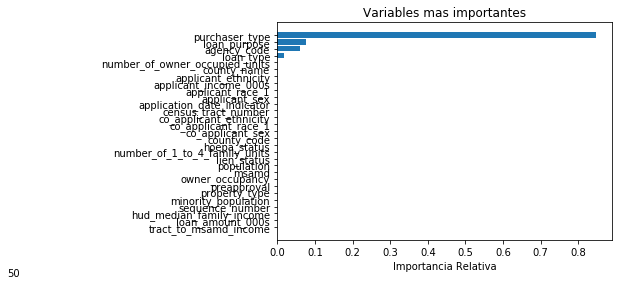

In [38]:
#ANALISIS DE IMPORTANCIA

import matplotlib.pyplot as plt
#Importance['Variable']
y_pos = np.arange(len(Importance['Valor']))

plt.barh(y_pos,Importance['Valor'],align='center')
plt.yticks(y_pos, Importance['Variable'])
plt.xlabel('Importancia Relativa')
plt.figtext(-0.5,0,50)
plt.title('Variables mas importantes')

In [152]:
cv_results.mean()
dtree.decision_path


<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [5]:
predictions=dtree.predict(test_X)
acc=sk.metrics.accuracy_score(test_y, predictions)
Predi = pd.DataFrame({'Class':test_y,
    'Predictions':predictions})
sk.metrics.confusion_matrix(test_y, predictions)
#PREDICE BIEN EL 1. El lo predice de una

NameError: name 'dtree' is not defined

In [161]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=10)
clf.fit(X=X, y=Y)
tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_,clf.best_estimator_)

C:\Users\rmaur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7156411730879816 {'max_depth': 5} DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [304]:
 adtree=DecisionTreeClassifier(max_depth=7,criterion='entropy',
                              class_weight= {1:2,2:1,3:2,4:1,5:1,6:1})
#PRUEBO UN MAX DEPTH 5, PERO CON 7 DA1 MEJORpy Y ENTROPIA

adtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight={1: 2, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1},
            criterion='entropy', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [313]:
 adtree=DecisionTreeClassifier(max_depth=7,criterion='entropy',
                              class_weight= {1:4,2:2,3:4,4:2,5:3,6:1})
#PRUEBO UN MAX DEPTH 5, PERO CON 7 DA1 MEJORpy Y ENTROPIA

adtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight={1: 4, 2: 2, 3: 4, 4: 2, 5: 3, 6: 1},
            criterion='entropy', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [314]:
predictions=adtree.predict(test_X)
acc=sk.metrics.accuracy_score(test_y, predictions)
acc

0.7068965517241379